In [73]:
from scipy.spatial.transform import Rotation as R
from scipy.special import sph_harm as sph
from pyshtools import legendre as pleg
from scipy.integrate import simps
import astropy.io.fits as pf
from math import sqrt, pi
import healpy as hp
import numpy as np
import time
NSIDE = 16
NPIX = hp.nside2npix(NSIDE)
Nmax = int(2*sqrt(hp.nside2npix(NSIDE)))
print(f"For NSIDE = {NSIDE}, numPix = {NPIX}, Nmax = int(2*sqrt(numPix)) = {Nmax}")
%matplotlib notebook

For NSIDE = 16, numPix = 3072, Nmax = int(2*sqrt(numPix)) = 110


In [74]:
"""
def restructure(ellArr, emmArr, lmax, coefs):
    count = 0
    newCoefs = np.zeros(coefs.shape[0], dtype=complex)
    for ell in range(lmax):
        for emm in range(ell+1): 
            index = np.where( (ellArr==ell) * (emmArr==emm) )[0][0]
            newCoefs[count] = coefs[index]
            count += 1
    return newCoefs
"""
def get_only_t(ellArr, emmArr, alm, lmax, t):
    count = 0
    almNew = np.zeros( int(lmax - t + 1), dtype=complex)
    for ell in range(t, lmax+1):
        index = np.where( (ellArr==ell) * (emmArr==t) )[0][0]
        almNew[count] = alm[index]
        count += 1
    return almNew
"""
def computePS(ellArr, emmArr, lmax, coefs):
    ps = np.zeros(lmax+1)
    for ell in range(lmax+1):
        index = np.where( (ellArr==ell) )[0]
        ps[ell] = (abs(coefs[index])**2).sum()# / (2*ell+1)
    return ps
"""

'\ndef computePS(ellArr, emmArr, lmax, coefs):\n    ps = np.zeros(lmax+1)\n    for ell in range(lmax+1):\n        index = np.where( (ellArr==ell) )[0]\n        ps[ell] = (abs(coefs[index])**2).sum()# / (2*ell+1)\n    return ps\n'

In [75]:
def make_map(theta, phi, data, NSIDE):
    """
    Makes healPy map given the map values on grid points and the grid coordinates.
    
    ==========================================================
    Inputs: (theta, phi, data, NSIDE)
    ----------------------------------------------------------
    theta - coordinate 1
    phi   - coordiante 2
    data  - value of map at [coordinate 1, coordinate 2]
    NSIDE - the NSIDE for the output healPy map
    ==========================================================
    Outputs: (map, mask, theta, phi)
    ----------------------------------------------------------
    map   - the healPy map 
    mask  - mask which contains information about missing data
    theta - coordinate 1 (healPy format)
    phi   - coordinate 2 (healPy format)
    ==========================================================
    
    """
    # checking if the input data is compatible
    assert len(theta) == len(phi) == len(data)
    
    _numPix = hp.nside2npix(NSIDE) # number of healPy pixels
    
    # creating map, mask, theta, phi, count arrays
    e1map = np.full(_numPix, hp.UNSEEN, dtype=complex)
    existance = np.full(_numPix, False, dtype=np.bool)
    counts = np.ones(_numPix, dtype=np.int) # used for averaging pixel data
    thetaNew = np.zeros(_numPix)
    phiNew = np.zeros(_numPix)
    
    for i, k in enumerate(data):
        _index = hp.ang2pix(NSIDE, theta[i], phi[i])
        thetaNew[_index], phiNew[_index] = hp.pix2ang(NSIDE, _index)
        if not existance[_index]:
            e1map[_index] = 0
            counts[_index] = 0
            existance[_index] = True
        e1map[_index] += k
        counts[_index] += 1
    print(f"Making healPy maps -- Complete")
    return e1map/counts, existance, thetaNew, phiNew

def make_map2(theta, phi, data, NSIDE, dth, dph):
    """
    Makes healPy map given the map values on grid points and the grid coordinates.
    
    ==========================================================
    Inputs: (theta, phi, data, NSIDE)
    ----------------------------------------------------------
    theta - coordinate 1
    phi   - coordiante 2
    data  - value of map at [coordinate 1, coordinate 2]
    NSIDE - the NSIDE for the output healPy map
    ==========================================================
    Outputs: (map, mask, theta, phi)
    ----------------------------------------------------------
    map   - the healPy map 
    mask  - mask which contains information about missing data
    theta - coordinate 1 (healPy format)
    phi   - coordinate 2 (healPy format)
    ==========================================================
    
    """
    # checking if the input data is compatible
    assert len(theta) == len(phi) == len(data)
    
    _numPix = hp.nside2npix(NSIDE) # number of healPy pixels
    
    # creating map, mask, theta, phi, count arrays
    e1map = np.full(_numPix, hp.UNSEEN, dtype=np.float)
    existance = np.full(_numPix, False, dtype=np.bool)
    thetaNew = np.zeros(_numPix)
    phiNew = np.zeros(_numPix)
    
    for i, k in enumerate(data):
        _index = hp.ang2pix(NSIDE, theta[i], phi[i])
        thetaNew[_index], phiNew[_index] = hp.pix2ang(NSIDE, _index)
        if not existance[_index]:
            e1map[_index] = 0
            existance[_index] = True
        e1map[_index] += k * np.sin(theta[i]) * dth * dph * _numPix / 4 / pi
    print(f"Making healPy maps -- Complete")
    return e1map, existance, thetaNew, phiNew

def make_map_vec(theta, phi, data, NSIDE):
    assert len(theta) == len(phi) == len(data)
    e1map = np.full(hp.nside2npix(NSIDE), hp.UNSEEN, dtype=np.float)
    existance = np.full(hp.nside2npix(NSIDE), False, dtype=np.bool)
    index = hp.ang2pix(NSIDE, theta, phi)
    thetaNew = np.zeros(12*NSIDE**2)
    phiNew = np.zeros(12*NSIDE**2)
    thetaNew[index], phiNew[index] = hp.pix2ang(NSIDE, index)
    values = np.fromiter((np.sum(data[index==i]) for i in np.unique(index)), float, count=len(np.unique(index)))
    e1map[np.unique(index)] = values
    existance[np.unique(index)] = True
    return e1map, existance, thetaNew, phiNew

In [76]:
def rotate_map_spin(hmap, rot_theta, rot_phi):
    """
    Take hmap (a healpix map array) and return another healpix map array 
    which is ordered such that it has been rotated in (theta, phi) by the 
    amounts given.
    """
    nside = hp.npix2nside(len(hmap[0]))

    # Get theta, phi for non-rotated map
    t,p = hp.pix2ang(nside, np.arange(hp.nside2npix(nside))) #theta, phi
    ct, cp, st, sp = np.cos(t), np.cos(p), np.sin(t), np.sin(p)
    vt = np.array([ct*cp, ct*sp, -st])
    vp = np.array([-sp, cp, 0.0*cp])

    # Define a rotator
    r = hp.Rotator(deg=False, rot=[rot_phi,rot_theta])

    # Get theta, phi under rotated co-ordinates
    trot, prot = r(t,p)
    ctR, cpR, stR, spR = np.cos(trot), np.cos(prot), np.sin(trot), np.sin(prot)
    vtR = np.array([ctR*cpR, ctR*spR, -stR])
    vpR = np.array([-spR, cpR, 0.0*cpR])

    # Interpolate map onto these co-ordinates
    rot_map0temp = hp.get_interp_val(hmap[0], trot, prot)
    rot_map1temp = hp.get_interp_val(hmap[1], trot, prot)
    
    rot_map0 = (vt*vpR).sum(axis=0) * rot_map0temp + (vp*vpR).sum(axis=0) * rot_map1temp
    rot_map1 = (vt*vtR).sum(axis=0) * rot_map0temp + (vp*vtR).sum(axis=0) * rot_map1temp

    return rot_map0, rot_map1

def rotate_map_spin_eul(hmap, eulAngle):
    """
    Take hmap (a healpix map array) and return another healpix map array 
    which is ordered such that it has been rotated in (theta, phi) by the 
    amounts given.
    """
    nside = hp.npix2nside(len(hmap[0]))

    # Get theta, phi for non-rotated map
    t,p = hp.pix2ang(nside, np.arange(hp.nside2npix(nside))) #theta, phi
    ct, cp, st, sp = np.cos(t), np.cos(p), np.sin(t), np.sin(p)
    vt = np.array([ct*cp, ct*sp, -st])
    vp = np.array([-sp, cp, 0.0*cp])
    
    # Define a rotator
    r = hp.rotator.Rotator(eulAngle, deg=False, eulertype='zxz')

    # Get theta, phi under rotated co-ordinates
    trot, prot = r(t,p)
    ctR, cpR, stR, spR = np.cos(trot), np.cos(prot), np.sin(trot), np.sin(prot)
    vtR = np.array([ctR*cpR, ctR*spR, -stR])
    vpR = np.array([-spR, cpR, 0.0*cpR])
    rotMat = R.from_euler('zxz', eulAngle).as_dcm()
    vtR = vtR.transpose().dot(rotMat).transpose()
    vpR = vpR.transpose().dot(rotMat).transpose()

    # Interpolate map onto these co-ordinates
    rot_map0temp = hp.get_interp_val(hmap[0], trot, prot)
    rot_map1temp = hp.get_interp_val(hmap[1], trot, prot)
    
    rot_map0 = (vt*vpR).sum(axis=0) * rot_map0temp + (vp*vpR).sum(axis=0) * rot_map1temp
    rot_map1 = (vt*vtR).sum(axis=0) * rot_map0temp + (vp*vtR).sum(axis=0) * rot_map1temp

    return rot_map0, rot_map1

def rotate_map(hmap, eulAngle):
    """
    Take hmap (a healpix map array) and return another healpix map array 
    which is ordered such that it has been rotated in (theta, phi) by the 
    amounts given.
    """
    nside = hp.npix2nside(len(hmap))

    # Get theta, phi for non-rotated map
    t,p = hp.pix2ang(nside, np.arange(hp.nside2npix(nside))) #theta, phi

    # Define a rotator
    r = hp.rotator.Rotator(eulAngle, deg=False, eulertype='zxz')

    # Get theta, phi under rotated co-ordinates
    trot, prot = r(t,p)

    # Interpolate map onto these co-ordinates
    rot_map = hp.get_interp_val(hmap, trot, prot)

    return rot_map

In [77]:
def restructure(ellArr, emmArr, lmax, coefs):
    """
    Restructures the alms into the format compatible with pleg
    
    i.e. newCoefs[0] corresponds to ell = 0, emm = 0
         newCoefs[1] corresponds to ell = 1, emm = 0
         newCoefs[2] corresponds to ell = 1, emm = 1
         newCoefs[3] corresponds to ell = 2, emm = 0
         newCoefs[4] corresponds to ell = 2, emm = 1 
         newCoefs[5] corresponds to ell = 2, emm = 2
         ..... and so on
    
    ===========================================================
    Inputs: (ellArr, emmArr, lmax, coefs)
    -----------------------------------------------------------
    ellArr  - array with ell corresponding to alms
    emmArr  - array with m corresponding to alms
    lmax    - maximum value of ell
    coefs   - alms
    ===========================================================
    Outputs: (newCoefs)
    -----------------------------------------------------------
    newCoefs - new alms in the format compatible with pleg
    ===========================================================
    
    """
    count = 0
    _maxind = int( (lmax + 1) * (lmax + 2) / 2 )
    newCoefs = np.zeros(_maxind, dtype=complex)
    for ell in range(lmax):
        for emm in range(ell+1): 
            index = np.where( (ellArr==ell) * (emmArr==emm) )[0][0]
            newCoefs[count] = coefs[index]
            count += 1
    return newCoefs

In [78]:
def gen_leg(lmax, theta):
    cost = np.cos(theta)
    sint = np.sin(theta)
    maxIndex = int( (lmax+1)*(lmax+2)/2 )
    leg = np.zeros( ( maxIndex, theta.size ) )
    leg_d1 = np.zeros( ( maxIndex, theta.size ) )
    dp_leg = np.zeros( (maxIndex, theta.size), dtype=complex)

    count = 0
    for z in cost:
        leg[:, count], leg_d1[:, count] = pleg.PlmBar_d1(lmax, z, 1, 1)
        count += 1
    dt_leg = leg_d1 * (-sint).reshape(1, sint.shape[0])
    
    ellArr = np.zeros(maxIndex)
    emmArr = np.zeros(maxIndex)
    countm, countl = 0, 0
    for i in range(maxIndex):
        ellArr[i] = countl
        emmArr[i] = countm
        if countm==countl:
            countl += 1
            countm = 0
        else:
            countm += 1
    norm = np.sqrt( ellArr * (ellArr + 1) )
    norm[norm<1] = 1.0
    
    legtemp = leg.copy()
    dp_leg = 1j * emmArr.reshape(maxIndex, 1) * legtemp / sint.reshape(1, sint.shape[0])
    dt_leg /= norm.reshape(maxIndex, 1)
    dp_leg /= norm.reshape(maxIndex, 1)
    return leg/sqrt(2)/sqrt(2*pi), dt_leg/sqrt(2)/sqrt(2*pi), dp_leg/sqrt(2)/sqrt(2*pi)

def compute_synth_PS(alm, lmax):
    pspec = np.zeros(lmax)
    count = 0
    for ell in range(lmax):
        for emm in range(ell+1):
            pspec[ell] += abs(alm[count]**2)
            count += 1
        pspec[ell] *= (ell+1)/(2*ell+1)
    return pspec

In [79]:
def minus1pow(m):
    if abs(m)%2==0:
        return 1
    else:
        return -1

# parameters for the synthetic map
lmaxSynth = 15 # maximum ell for the radial map
maxNum = int((lmaxSynth+1)*(lmaxSynth+2)/2)
almSynth = np.zeros(maxNum)
ellSynth = np.zeros(maxNum)

theta = np.linspace(0, pi - 1e-4, Nmax).reshape(Nmax, 1)
phi = np.linspace(-pi + 1e-4, pi - 1e-4, Nmax).reshape(1, Nmax)
dth = theta[1, 0] - theta[0, 0]
dph = phi[0, 1] - phi[0, 0]
y = np.sin(theta) * np.sin(phi)
z = np.cos(theta) * np.ones(phi.shape)
PHIROT = np.arctan2(z, y)
THETAROT = np.arcsin(np.sqrt( y**2 + z**2 ))
PHI, THETA = np.meshgrid(phi, theta)

theta = np.linspace(1e-4, pi - 1e-4, Nmax).reshape(Nmax, 1)
phi = np.linspace(-pi + 1e-4, pi - 1e-4, Nmax).reshape(1, Nmax)
y = np.sin(theta) * np.sin(phi)
z = np.cos(theta) * np.ones(phi.shape)
PHIROT = np.arctan2(z, y)
THETAROT = np.arcsin(np.sqrt( y**2 + z**2 ))
PHI, THETA = np.meshgrid(phi, theta)

mapr = (np.random.rand(Nmax, Nmax) - 0.5)*500
mapt = (np.random.rand(Nmax, Nmax) - 0.5)*30000*np.sin(theta)
mapp = (np.random.rand(Nmax, Nmax) - 0.5)*3000*np.sin(theta)

leg, dt_leg, dp_leg = gen_leg(lmaxSynth, theta.flatten())

almR = np.zeros(maxNum, dtype=complex)
almP = np.zeros(maxNum, dtype=complex)
almM = np.zeros(maxNum, dtype=complex)
ulm = np.zeros(maxNum, dtype=complex)
vlm = np.zeros(maxNum, dtype=complex)
wlm = np.zeros(maxNum, dtype=complex)

#mapr.imag, mapt.imag = 0.0, 0.0
T_leg = dt_leg - 1j*dp_leg
P_leg = dt_leg + 1j*dp_leg

count = 0
for ell in range(lmaxSynth):
    for emm in range(ell+1):
        cosmp = np.cos(emm*phi)
        sinmp = np.sin(emm*phi)
        eimp = (cosmp - 1j*sinmp).reshape(1, Nmax) * minus1pow(emm)
        almR[count] = simps( simps( mapr * ( leg[count, :].reshape(Nmax, 1) * eimp ) * np.sin(theta), axis=0, x=theta.flatten()), x=phi.flatten())
        almP[count] = simps( simps( (mapt + 1j*mapp)* ( dt_leg[count, :].reshape(Nmax, 1) * eimp ) * np.sin(theta), axis=0, x=theta.flatten()), x=phi.flatten())
        almM[count] = simps( simps( (mapt - 1j*mapp) * ( dp_leg[count, :].reshape(Nmax, 1) * eimp ) * np.sin(theta), axis=0, x=theta.flatten()), x=phi.flatten())
        ulm[count] = simps( simps( mapr * ( leg[count, :].reshape(Nmax, 1) * eimp ) * np.sin(theta), axis=0, x=theta.flatten()), x=phi.flatten())
        vlm[count] = simps( simps( ( mapt * ( dt_leg[count, :].reshape(Nmax, 1) * eimp ) +\
                                  mapp * ( dp_leg[count, :].reshape(Nmax, 1) * eimp ) ) * np.sin(theta), axis=0, x=theta.flatten()), x=phi.flatten())
        wlm[count] = simps( simps( ( mapp * ( dt_leg[count, :].reshape(Nmax, 1) * eimp ) -\
                                  mapp * ( dp_leg[count, :].reshape(Nmax, 1) * eimp ) ) * np.sin(theta), axis=0, x=theta.flatten()), x=phi.flatten())
        count += 1
print("Explicit computation of alms -- Complete")

Explicit computation of alms -- Complete


In [80]:
hpMapR, _mask, _th, _ph = make_map(THETA.flatten(), PHI.flatten(), mapr.flatten(), NSIDE)
hpMapT, _mask, _th, _ph = make_map(THETA.flatten(), PHI.flatten(), mapt.flatten(), NSIDE)
hpMapP, _mask, _th, _ph = make_map(THETA.flatten(), PHI.flatten(), mapp.flatten(), NSIDE)


#phmask = (_ph<pi/2) + (_ph>3*pi/2)
#mapp[~phmask] = 0.0

#masking to simulate observed sun
#thmask = (_th>pi/2)
#mapp[thmask] = 0.0
#hp.mollview(mapp, cmap='seismic')



Making healPy maps -- Complete
Making healPy maps -- Complete
Making healPy maps -- Complete


In [81]:
hpalmR = hp.map2alm(hpMapR)
trans = [hpMapT, hpMapP]
transRot = rotate_map_spin_eul(trans, np.array([0.0, -pi/2, 0.0]))

#trans = [0.5*(hpMapT + hpMapP), -0.5*1j*(hpMapT - hpMapP)]
#map0[~mask0] = hp.UNSEEN
#map_trans[0][~maskp] = 0.0#hp.UNSEEN
#map_trans[1][~maskp] = 0.0#hp.UNSEEN
hpalmPM = hp.map2alm_spin(trans, 1)
hpalmPMRot = hp.map2alm_spin(transRot, 1)

# getting ellmax, ellArr and emmArr
ellmax = hp.sphtfunc.Alm.getlmax(len(hpalmR))
ellArr, emmArr = hp.sphtfunc.Alm.getlm(ellmax)

almR_hp = restructure(ellArr, emmArr, lmaxSynth, hpalmR)
almP_hp = restructure(ellArr, emmArr, lmaxSynth, hpalmPM[0])
almM_hp = restructure(ellArr, emmArr, lmaxSynth, hpalmPM[1])
#almP_hp = restructure(ellArr, emmArr, lmaxSynth, 0.5*( hpalmPM[0] - hpalmPM[1]) )
#almM_hp = restructure(ellArr, emmArr, lmaxSynth, -0.5j*( hpalmPM[0] + hpalmPM[1]) )
print(ellmax, len(hpalmR), len(almR_hp), lmaxSynth)

47 1176 136 15


<IPython.core.display.Javascript object>


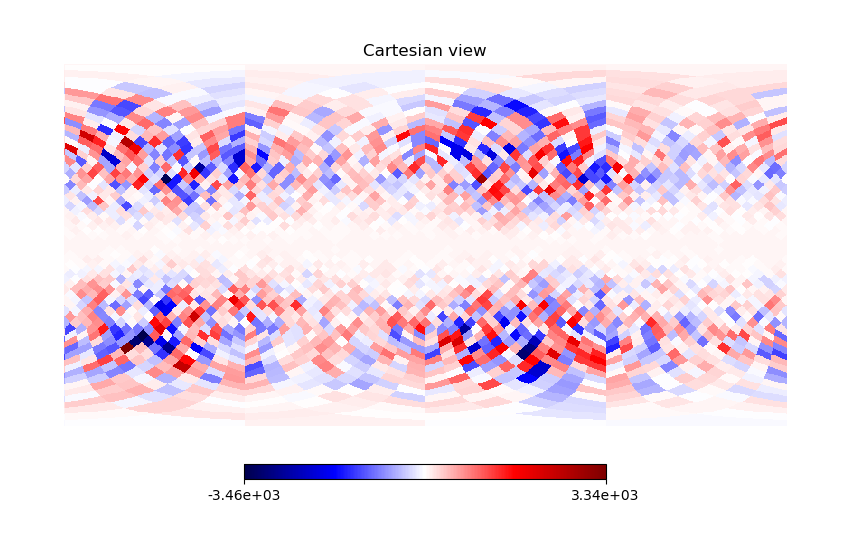

<IPython.core.display.Javascript object>


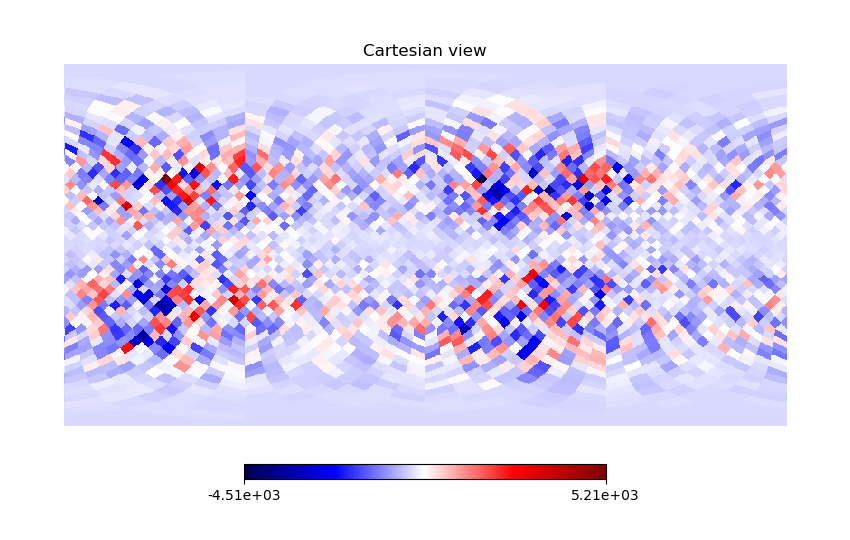

In [97]:
maprRot = rotate_map(hpMapR, np.array([0.0, -pi/2, 0.0]))
npix = hp.nside2npix(NSIDE)
_index = np.arange(npix)
thRot, phRot = hp.pix2ang(NSIDE, _index)
thmask = thRot>pi/2
lr = np.cos(thRot)
lt = -np.sin(thRot)
losMap = lr*maprRot + lt*(transRot[0])
#losMap[thmask] = 0.0

maprRot = losMap * lr
maphRot = losMap * lt
almNew = hp.map2alm(maprRot)
almNewPM = hp.map2alm_spin([maphRot, 0*maphRot], 1)

ps_r  = computePS(ellArr, emmArr, ellmax, almNew)
ps_v  = computePS(ellArr, emmArr, ellmax, almNewPM[0])
ps_w  = computePS(ellArr, emmArr, ellmax, almNewPM[1])
ell = np.arange(ellmax+1)

hp.cartview(maprRot, cmap='seismic')
hp.cartview(maphRot, cmap='seismic')

<IPython.core.display.Javascript object>


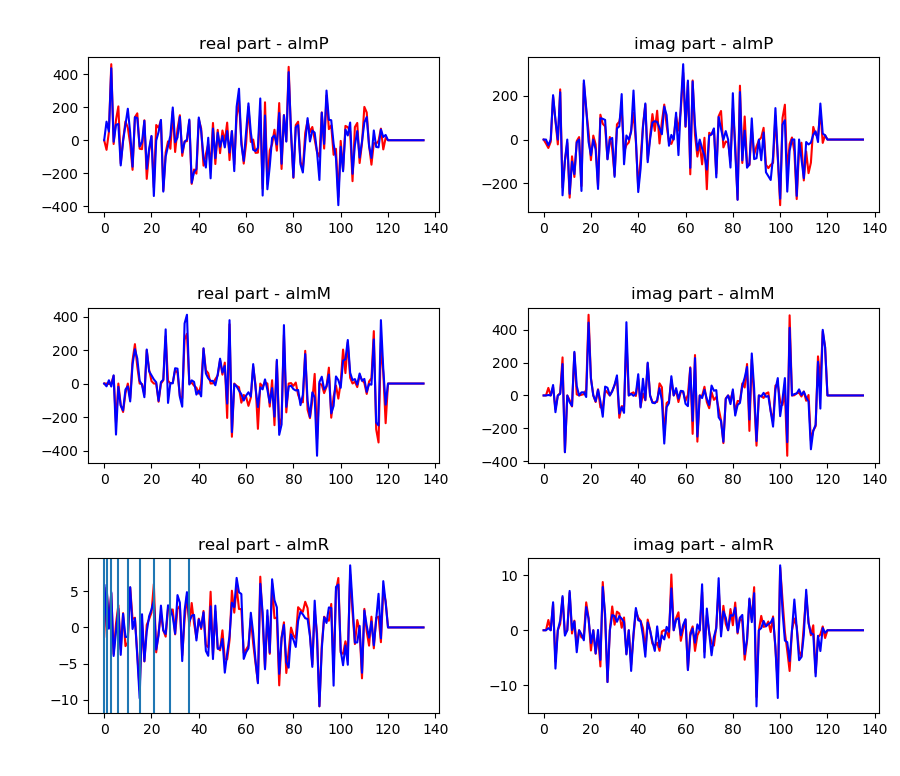

In [83]:
synthALMR = almR
synthALMP = almP

plt.figure()

plt.subplot(321)
plt.plot(almP.real, 'r')
plt.plot(almP_hp.real, 'b')
plt.title('real part - almP')

plt.subplot(322)
plt.plot(almP.imag, 'r')
plt.plot(almP_hp.imag, 'b')
plt.title('imag part - almP')

plt.subplot(323)
plt.plot(almM.real, 'r')
plt.plot(almM_hp.real, 'b')
plt.title('real part - almM')

plt.subplot(324)
plt.plot(almM.imag, 'r')
plt.plot(almM_hp.imag, 'b')
plt.title('imag part - almM')

plt.subplot(325)
plt.plot(almR.real, 'r')
plt.plot(almR_hp.real, 'b')
plt.axvline(x=0)
plt.axvline(x=1)
plt.axvline(x=3)
plt.axvline(x=6)
plt.axvline(x=10)
plt.axvline(x=15)
plt.axvline(x=21)
plt.axvline(x=28)
plt.axvline(x=36)
#plt.plot(almSynth.real, 'g')
plt.title('real part - almR')

plt.subplot(326)
plt.plot(almR.imag, 'r')
plt.plot(almR_hp.imag, 'b')
#plt.plot(almSynth.imag, 'g')
plt.title('imag part - almR')

plt.tight_layout()
plt.show()

In [84]:
# hp.alm2map_spin(alms(size2list), nside, spin, lmax, mmax(opt))
"""
import pickle as pkl
with open("alm.pkl", 'wb') as f:
    pkl.dump(alm_pm, f)

np.savetxt("/home/samarth/dopplervel2/alm_pm", alm_pm)
"""
#mapNew = hp.alm2map_spin(alm_pm, NSIDE, 1, 3*NSIDE-1)
ps_r  = computePS(ellArr, emmArr, ellmax, hpalmR)
ps_v  = computePS(ellArr, emmArr, ellmax, hpalmPMRot[0])
ps_w  = computePS(ellArr, emmArr, ellmax, hpalmPMRot[1])
ell = np.arange(ellmax+1)

<IPython.core.display.Javascript object>


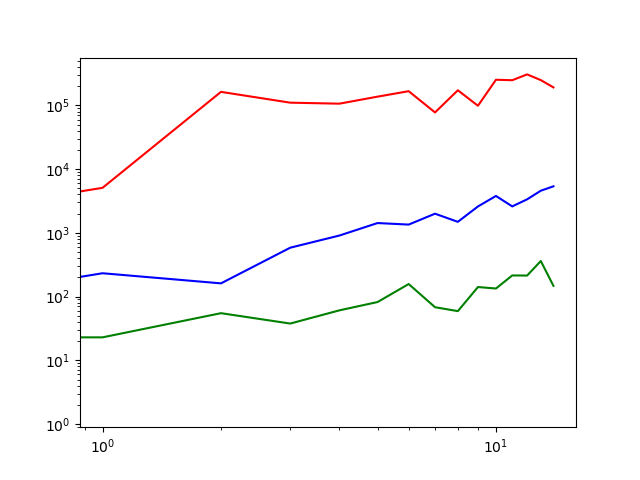

<IPython.core.display.Javascript object>


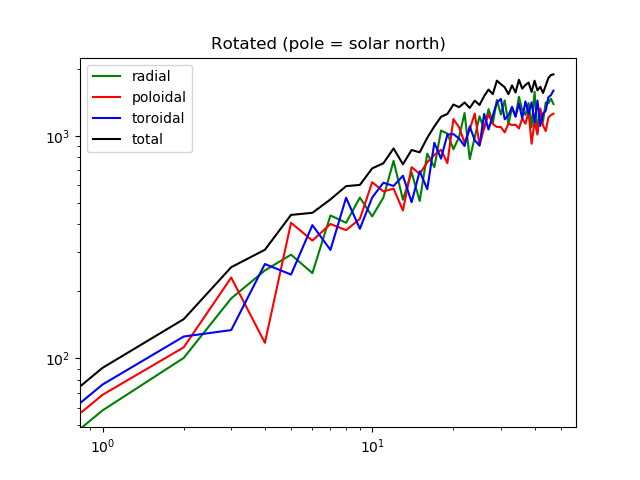

In [98]:
upow = compute_synth_PS(ulm, lmaxSynth)
vpow = compute_synth_PS(vlm, lmaxSynth)
wpow = compute_synth_PS(wlm, lmaxSynth)
plt.figure()
plt.loglog(upow, 'g')
plt.loglog(vpow, 'r')
plt.loglog(wpow, 'b')
plt.show()

plt.figure()
plt.loglog(ell, np.sqrt( ps_r * ell  ), 'g', label='radial')
plt.loglog(ell, np.sqrt( ps_v * ell  ), 'r', label='poloidal')
plt.loglog(ell, np.sqrt( ps_w * ell  ), 'b', label='toroidal')
plt.loglog(ell, np.sqrt( np.sqrt ( abs(ps_r)**2 + abs(ps_v)**2 + abs(ps_w)**2 ) * ell  ), 'black', label='total')
plt.title("Rotated (pole = solar north)")
plt.legend()

plt.show()

<IPython.core.display.Javascript object>


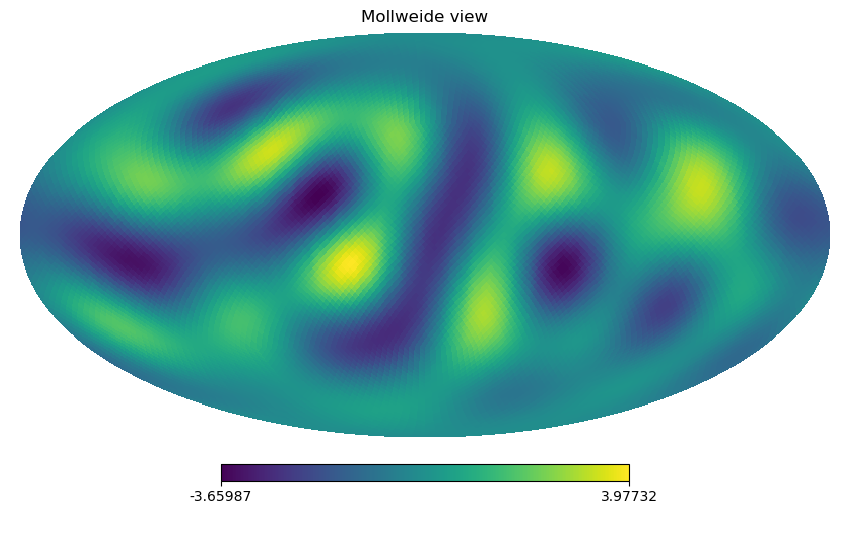

<IPython.core.display.Javascript object>


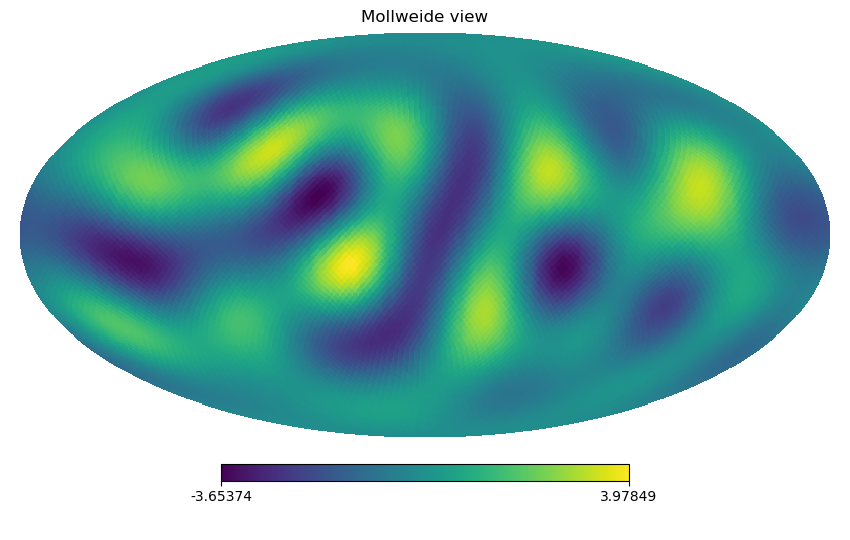

In [24]:
hp.mollview(mapNew[0])
hp.mollview(mapp)

<IPython.core.display.Javascript object>


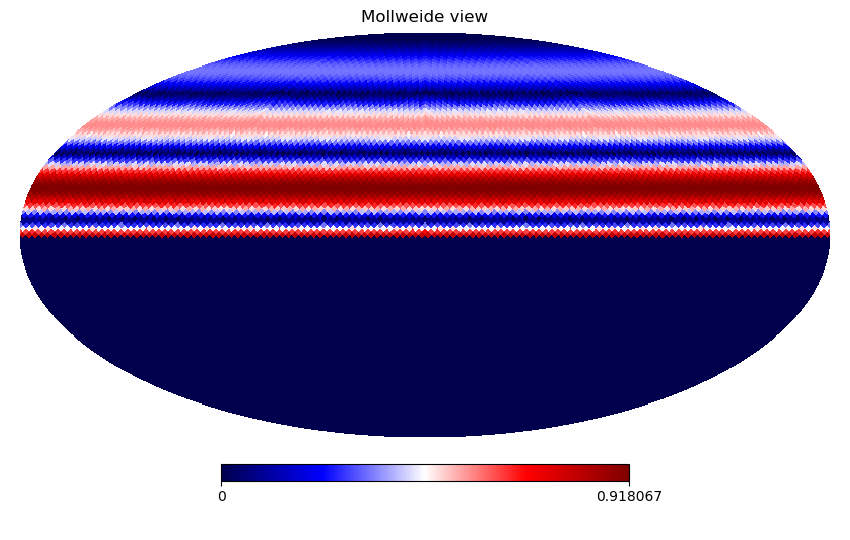

<IPython.core.display.Javascript object>


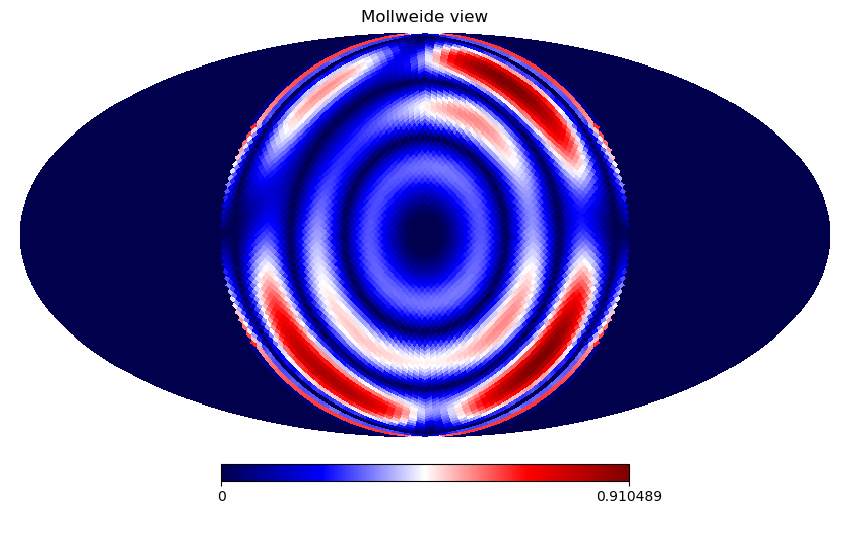

<IPython.core.display.Javascript object>


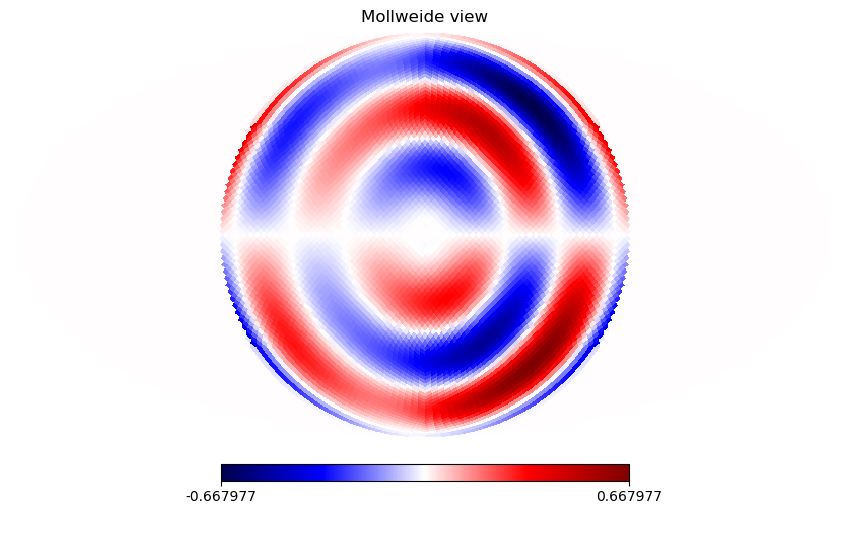

<IPython.core.display.Javascript object>


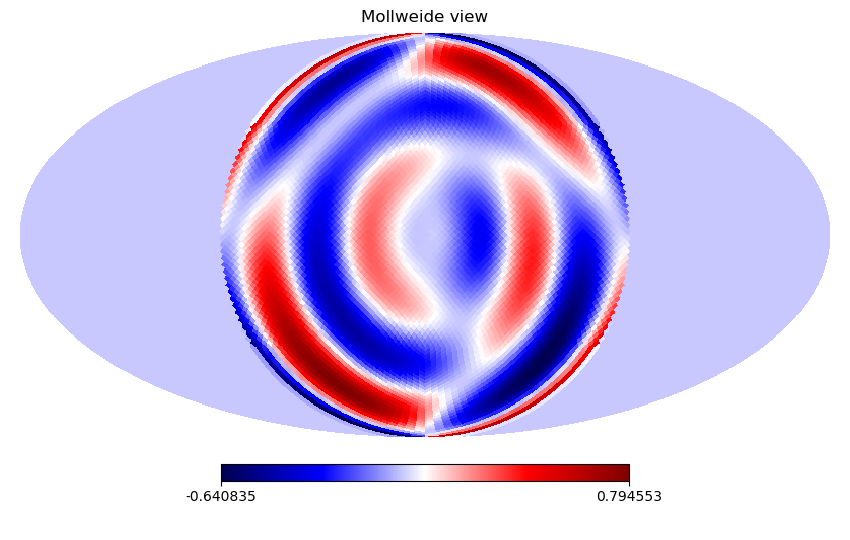

In [113]:
onesMap = np.ones(map_trans[0].shape[0])
#newMap = rotate_map_spin((onesMap, 0.0*onesMap), 0.0, pi/2)
#newMap = rotate_map_spin(map_trans, 0.0, 1.8) 
newMap = rotate_map_spin_eul(map_trans, np.array([0.0, -pi/2, 0])) 
hp.mollview(abs(map_trans[0]), cmap='seismic')
hp.mollview(np.sqrt( abs(newMap[0])**2 + abs(newMap[1])**2 ), cmap='seismic')
hp.mollview(newMap[0], cmap='seismic')
hp.mollview(newMap[1], cmap='seismic')

<IPython.core.display.Javascript object>


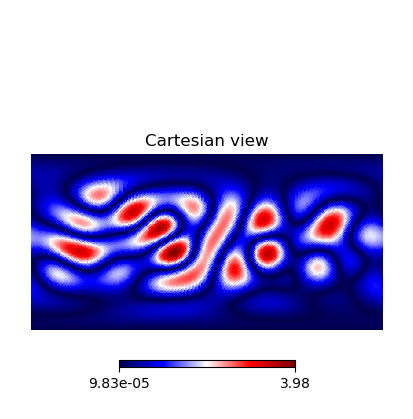

<IPython.core.display.Javascript object>


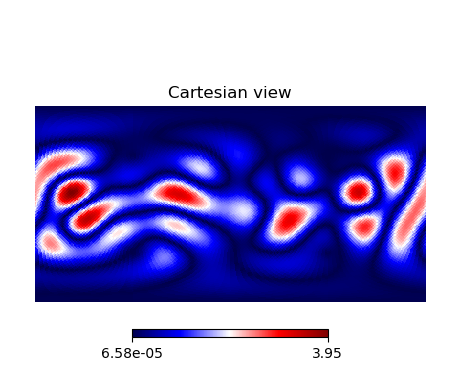

<IPython.core.display.Javascript object>


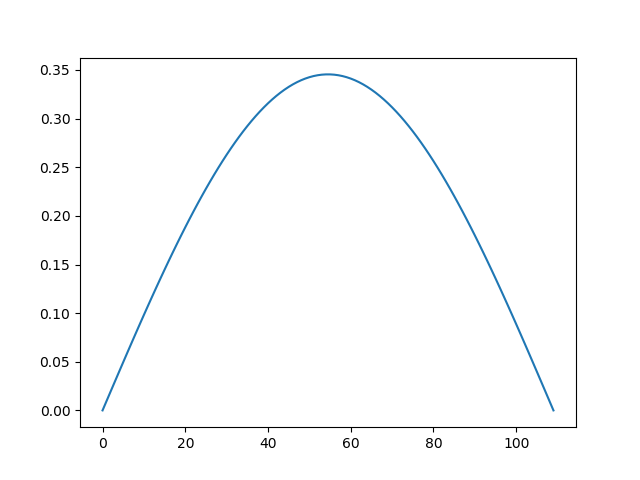

In [73]:
plt.figure()
plt.plot(leg[2, :])# * np.sin(theta).flatten())
plt.show()

array([[0.28209479+0.j, 0.28209479+0.j, 0.28209479+0.j, ...,
        0.28209479+0.j, 0.28209479+0.j, 0.28209479+0.j],
       [0.28209479+0.j, 0.28209479+0.j, 0.28209479+0.j, ...,
        0.28209479+0.j, 0.28209479+0.j, 0.28209479+0.j],
       [0.28209479+0.j, 0.28209479+0.j, 0.28209479+0.j, ...,
        0.28209479+0.j, 0.28209479+0.j, 0.28209479+0.j],
       ...,
       [0.28209479+0.j, 0.28209479+0.j, 0.28209479+0.j, ...,
        0.28209479+0.j, 0.28209479+0.j, 0.28209479+0.j],
       [0.28209479+0.j, 0.28209479+0.j, 0.28209479+0.j, ...,
        0.28209479+0.j, 0.28209479+0.j, 0.28209479+0.j],
       [0.28209479+0.j, 0.28209479+0.j, 0.28209479+0.j, ...,
        0.28209479+0.j, 0.28209479+0.j, 0.28209479+0.j]])

In [127]:
simps( simps( sph(-1, 1, phi, theta) * sph(-1, 1, phi, theta).conjugate() * np.sin(theta), axis=0, x=theta.flatten()), x=phi.flatten())

(0.9999681669323566+0j)